# Homework 5 - The Marvel Universe!

Superheroes and abilities have always existed in the human imagination. Marvel has one of the largest superhero comic book franchises. Famous superheroes, including Spider-Man, Iron Man, Captain America, and Thor, are among its cast, as are well-known superhero teams like the Avengers, X-Men, Fantastic Four, and Guardians of the Galaxy. Additionally, it has famous supervillains, including Doctor Doom, Magneto, Ultron, and Thanos, in its stable. Most of Marvel's fictional characters function in a single reality known as the Marvel Universe, with many of their headquarters located in New York City. These comics are well-known today because of their use in movies. If you do not know who we are talking about, [give this link a look](https://www.marvel.com/explore) and learn more about the characters.

This time, you and your team have decided to dive deep into Marvel's social network. Now, you will deal with graphs to determine relevant characteristics and highlights from the relations among those superheroes.

Let's hands-on this!

# VERY VERY IMPORTANT!

1. !!! Read the entire homework before coding anything!!!

2. My solution it's not better than yours, and yours is not better than mine. In any data analysis task, there is not a unique way to solve a problem. For this reason, it is crucial (necessary and mandatory) that you describe any single decision you take and all the steps you do.

3. Once performed any exercise, comments about the obtained results are mandatory. We are not always explicit about where to focus your comments, but we will always want brief sentences about your discoveries and decisions.

In this Homework, you will explore the Marvel Comics Universe, exploring relations between heroes and villains in the comics!

- __Backend__: where you need to develop efficient algorithms that define the functionalities of the system
- __Frontend__: where you provide visualization for queries entered by the user

__IMPORTANT:__ The main functions for each functionality should be written from scratch in the backend part. Nevertheless, you can use the data structures provided by networkx (such as closeness_centrality, betweenness_centrality, pagerank, or any other function that can help you as an intermediate step for your main functionalities).

In the visualization part, you can use any available function (networkx functions are highly recommended).

## 1. Data

To get started, you have to download the data, as always, from [here](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network?select=hero-network.csv). Make sure you downloaded all files because we will work with them all.

In particular, the files contain the following:

- __nodes.csv__ - Contains two columns (node, type), indicating the nodes' name and type (comic, hero).
- __edges.csv__ - Contains two columns (hero, comic), indicating which comics the heroes appear in.
- __hero-network.csv__ - Contains the network of heroes who have appeared together in the comics.

### Graphs setup

For this homework, we are going to build two different graphs:

1. __First graph:__ Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

2. __Second graph:__ The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

### Data Preprocessing

As always, in the data science area, you can find some inconsistencies in the provided data. Therefore, some modifications should be made to the data to make it consistent across all of the datasets you have. To ensure consistency in the data, keep the following in mind:

1. Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency exists for the following reasons:
- Some heroes' names in 'hero-netowrk.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'.
- Some heroes' names in 'hero-netowrk.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'.
- The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'.

2. Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.



In [2]:
import pandas as pd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import random
from typing import List, Tuple, Set, Union
from tabulate import tabulate
from pyspark import SparkContext

Upload the datasets

In [ ]:
# Contains the network of heroes who have appeared together in the comics.
df_hero = pd.read_csv('hero-network.csv')
print(df_hero.shape)
display(df_hero.head())

(574467, 2)


,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [ ]:
# Contains two columns (hero, comic), indicating which comics the heroes appear in.
df_edges = pd.read_csv('edges.csv')
print(df_edges.shape)
display(df_edges.head())

(96104, 2)


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


In [ ]:
# Contains two columns (node, type), indicating the nodes' name and type (comic, hero).
df_nodes = pd.read_csv('nodes.csv')
print(df_nodes.shape)
display(df_nodes.head())

(19090, 2)


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


#### Preprocessing

Remove any trailing spaces or '/' in the names:

In [ ]:
print(df_hero.nunique())
df_hero["hero1"] = df_hero["hero1"].apply(lambda x: x.rstrip('/ '))
df_hero["hero2"] = df_hero["hero2"].apply(lambda x: x.rstrip('/ '))
print(df_hero.nunique())

hero1    6211
hero2    6173
dtype: int64
hero1    6206
hero2    6169
dtype: int64


Adjust Spiderman's name to make it consistent with other datasets:

- Visualize and see how many there are for column 'hero1':

In [ ]:
print(df_hero[df_hero["hero1"]=='SPIDER-MAN/PETER PAR'].shape)
display(df_hero[df_hero["hero1"]=='SPIDER-MAN/PETER PAR'].head())

(6652, 2)


,hero1,hero2
398,SPIDER-MAN/PETER PAR,FIRESTAR/ANGELICA JO
399,SPIDER-MAN/PETER PAR,THUNDERBALL/DR. ELIO
400,SPIDER-MAN/PETER PAR,NAMORITA/NITA PRENTI
401,SPIDER-MAN/PETER PAR,SPEEDBALL/ROBBIE BAL
402,SPIDER-MAN/PETER PAR,HULK/DR. ROBERT BRUC


- Change the name and check that the rows with the old name are 0:

In [ ]:
df_hero.hero1[df_hero["hero1"]=='SPIDER-MAN/PETER PAR'] = 'SPIDER-MAN/PETER PARKER'
print(df_hero[df_hero["hero1"]=='SPIDER-MAN/PETER PAR'].shape)

(0, 2)


- Check that the lines with the new name are the same number as the starting ones and display them:

In [ ]:
print(df_hero[df_hero["hero1"]=='SPIDER-MAN/PETER PARKER'].shape)
display(df_hero[df_hero["hero1"]=='SPIDER-MAN/PETER PARKER'].head())

(6652, 2)


,hero1,hero2
398,SPIDER-MAN/PETER PARKER,FIRESTAR/ANGELICA JO
399,SPIDER-MAN/PETER PARKER,THUNDERBALL/DR. ELIO
400,SPIDER-MAN/PETER PARKER,NAMORITA/NITA PRENTI
401,SPIDER-MAN/PETER PARKER,SPEEDBALL/ROBBIE BAL
402,SPIDER-MAN/PETER PARKER,HULK/DR. ROBERT BRUC


- Repeat the steps for the 'hero2' column

In [ ]:
df_hero.hero2[df_hero["hero2"]=='SPIDER-MAN/PETER PAR'] = 'SPIDER-MAN/PETER PARKER'
print(df_hero[df_hero["hero2"]=='SPIDER-MAN/PETER PARKER'].shape)
display(df_hero[df_hero["hero2"]=='SPIDER-MAN/PETER PARKER'].head())

(7065, 2)


,hero1,hero2
397,NOVA/RICHARD RIDER,SPIDER-MAN/PETER PARKER
1505,"STACY, PAUL",SPIDER-MAN/PETER PARKER
1510,"STACY, JILL",SPIDER-MAN/PETER PARKER
1514,"STACY, ARTHUR",SPIDER-MAN/PETER PARKER
1517,"PARKER, MAY",SPIDER-MAN/PETER PARKER


Delete the rows that have the same heroes on the two columns

In [ ]:
print(df_hero.shape)
display(df_hero[df_hero["hero1"]==df_hero["hero2"]].head())
print(df_hero[df_hero["hero1"]==df_hero["hero2"]].shape)
df_hero = df_hero[df_hero["hero1"]!=df_hero["hero2"]]
print(df_hero.shape)
print(df_hero[df_hero["hero1"]==df_hero["hero2"]].shape)

(574467, 2)


,hero1,hero2
8888,MISS AMERICA/MADELIN,MISS AMERICA/MADELIN
8889,MISS AMERICA/MADELIN,MISS AMERICA/MADELIN
8890,MISS AMERICA/MADELIN,MISS AMERICA/MADELIN
8891,MISS AMERICA/MADELIN,MISS AMERICA/MADELIN
8892,MISS AMERICA/MADELIN,MISS AMERICA/MADELIN


(2232, 2)
(572235, 2)
(0, 2)


#### Create the first Graph

- As a first step add a column called 'weight' which is calculated as the inverse of the number of links between one node and another:


In [ ]:
df_hero["weight"] = df_hero.groupby(["hero1", "hero2"])['hero2'].transform(lambda x: math.exp(-x.count()/100))
print(df_hero.shape)
display(df_hero.head())

(572235, 3)


,hero1,hero2,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,0.951229
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.960789
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,0.960789
3,"LITTLE, ABNER",PRINCESS ZANDA,0.951229
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.960789


- Create the graph using 'Graph' to have it indirect:

In [ ]:
G1 = nx.from_pandas_edgelist(df_hero, "hero1", "hero2", "weight", create_using=nx.Graph())

- Display the number of nodes and the number of edges of the created graph:

In [ ]:
print(f'Number of nodes: {G1.number_of_nodes()}')
print(f'Number of edges: {G1.number_of_edges()}')

Number of nodes: 6421
Number of edges: 167100


- Save the graph created with pickle:


In [ ]:
with open("G1.pkl", "wb") as file:
    pickle.dump(G1, file)
# to read the file if needed
#with open("G1.pkl", "rb") as file:
#    G1 = pickle.load(file)

#### Create the second graph

- Add the nodes to the Graph

In [ ]:
G2 = nx.from_pandas_edgelist(df_edges, "hero", "comic", create_using=nx.Graph())

- Add the nodes and their attributes to the graph:


In [ ]:
G2.add_nodes_from(df_nodes["node"], type=df_nodes["type"])

- Display the number of nodes and the number of edges of the created graph:

In [ ]:
print(f'Number of nodes: {G2.number_of_nodes()}')
print(f'Number of edges: {G2.number_of_edges()}')

Number of nodes: 19091
Number of edges: 96104


- Save the graph created with pickle:


In [ ]:
with open("G2.pkl", "wb") as file:
    pickle.dump(G2, file)
# to read the file if needed
#with open("G2.pkl", "rb") as file:
#    G2 = pickle.load(file)

## 2. Backend Implementation

The goal of this part is the implementation of a controller system that has different functionalities. The controller should take as input an identifier "i" and run the associated function_i applied to the graph you create from the downloaded data.

__Definition:__ As the number of nodes and edges grows, we may request to work on a subset of the data to reduce computation time and improve network visualization. In this case, we will ask you only to consider the data for __top N heros__. We define the top N heroes as follows:

- __Top N heroes:__ The top N heroes who have appeared in the most number of comics. The 'edges.csv' file, which represents the comics in which each hero has appeared, can be used to filter these N heroes.

__Note:__ When the value of N is not set by the user, the function should consider the whole data.

### Functionality 1 - extract the graph's features

Input:

- The graph data
- The graph type (ex., number 1 or number 2)
- N: denoting the top N heroes that their data should be considered

Output:

- The number of nodes in the network (if type 2, report for both node types)
- The number of collaborations of each superhero with the others (only if type 1)
- The number of heroes that have appeared in each comic (only if type 2)
- The network's density
- The network's degree distribution
- The average degree of the network
- The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the Network is sparse or dense

__Note:__ For this case, it makes sense to differentiate operations between the two graphs: for example, when computing hubs for the second graph, we likely care only about comics.


In [ ]:
df_edges['hero'].value_counts()

SPIDER-MAN/PETER PARKER    1577
CAPTAIN AMERICA            1334
IRON MAN/TONY STARK        1150
THING/BENJAMIN J. GR        963
THOR/DR. DONALD BLAK        956
                           ... 
PROGENITOR                    1
DOMANI, DINO                  1
DOGGEREL                      1
DOCTOR, DR. JOSHUA            1
24-HOUR MAN/EMMANUEL          1
Name: hero, Length: 6439, dtype: int64

It's time to extract a list with the names of the top N heroes for G1 and a list with the names of the top N heroes and all the neighbors comics for G2. That's because G2 is a *bipartite graph*, so if we extract only the heroes nodes they will have degree equal to 0. So, for the G2 case, we choose to insert in the list of the top N also all the comic nodes near the hero.


In [ ]:
def top_N_G1(data,N=G1.number_of_nodes()):
    top=data['hero'].value_counts().head(N)
    hero_list=top.index.tolist()
    return hero_list

In [ ]:
def top_N_G2(data,N=G2.number_of_nodes()):
    top_hero=data['hero'].value_counts().head(N)
    hero_list=top_hero.index.tolist()
    for i in hero_list:
        top_comic=[n for n in G2.neighbors(i)]
    top=hero_list + top_comic
    return top, top_comic

For the first functionality we want to extract some features from the Graph that the function takes in input.

In [ ]:
def features(data, G, N):

    if G == G1:
        hero_list=top_N_G1(data, N)
        #create a subgraph with the top heros nodes
        top=G.subgraph(hero_list)
        #number of nodes
        n_nodes=top.number_of_nodes()
        #number of collaborations of each superhero with the others
        degree=top.degree()
        #create a list with all the degree for each node
        degrees=[top.degree(n) for n in top.nodes()]
        #find the density
        density=round(nx.density(top),1)

        #decide when the Network is sparse or dense
        if density >0.6:
            types='Dense'
        else:
            types='Sparse'

        #find avarage degree
        ave_degree=(2*top.number_of_edges())/top.number_of_nodes()
        arr=np.array(degrees)
        #save th 95th percentile
        perc=np.percentile(arr, 95)
        #extract nodes having degrees more extensive than the 95th percentile
        hub=arr[arr >= perc]
        d=dict(top.degree())

        #save the hubs
        H=[]
        for i in hub:
            H.append(list(d.keys())[list(d.values()).index(i)])
        Hub=list(set(H))
        out=(n_nodes, degree, degrees, density, ave_degree, Hub, types)
        
    elif G== G2:
        list_G2,top_comic=top_N_G2(data, N)
        #create a subgraph eith the top heros and comics nodes
        top=G.subgraph(list_G2)
        #number of nodes
        n_nodes=top.number_of_nodes()
        heros=list(set(df_edges['hero']))
        #number of heroes that have appeared in each comic
        number_heros=top.degree(heros)
        #create a list with all the degree for each node
        degrees=[top.degree(n) for n in top.nodes()]
        #find the density
        density=round(nx.density(top),1)

        #decide when the Network is sparse or dense
        if density >0.6:
            types='Dense'
        else:
            types='Sparse'

        #find avarage degree
        ave_degree=(2*top.number_of_edges())/top.number_of_nodes()
        #hubs only for the comics
        comic=[top.degree(n) for n in top_comic]
        arr=np.array(comic)
        #save th 95th percentile
        perc=np.percentile(arr, 95)
        #extract nodes having degrees more extensive than the 95th percentile
        hub=arr[arr >= perc]
        d={top_comic[i]: comic[i] for i in range(len(top_comic))}

        #save the hubs
        H=[]
        for i in hub:
            H.append(list(d.keys())[list(d.values()).index(i)])
        Hub=list(set(H))
        out=(n_nodes, number_heros, degrees, density, ave_degree, Hub, types)
    
    else:
        raise ValueError('Invalid graph')

    return out

### Functionality 2 - Find top superheroes!

Input:

- The graph data
- A node (hero or comic)
- One of the given metrics : Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality
- N: denoting the top N heroes that their data should be considered

Output:

- The metric's value over the considered graph
- The given node's value

__Note:__ Give an explanation regarding the features of the user based on all of the metrics (e.g. if the betweenness metric is high, what does this mean in practice, what if the betweenness is low but has a high PageRank value, etc.).

The second functionality regard finding for a specific node the centrality measures.

In [ ]:
def top_superheroes(data, node, metric, N):
    #create the subgraph
    hero_list, top_comic=top_N_G2(data,N)
    G=G2.subgraph(hero_list)
    
    #check of the input metric
    if metric == 'betweenness_centrality':
        metric_values = nx.betweenness_centrality(G)
    elif metric == 'pagerank':
        metric_values = nx.pagerank(G)
    elif metric == 'closeness_centrality':
        metric_values = nx.closeness_centrality(G)
    elif metric == 'degree_centrality':
        metric_values = nx.degree_centrality(G)
    else:
        raise ValueError('Invalid metric')

    keys=[]
    values=[]
    #save the value of the input node
    for key, value in metric_values.items(): 
        #take only the keys for each node of the specific metric
        keys.append(key)
        #take only the values for each node of the specific metric
        values.append(value)
    for i in range(len(keys)):
        if keys[i]==node:
            node_value=values[i]
    #save the output
    out=values, node_value

    return out

**The main centrality measures are:**
* _**Betweenness Centrality:**_ This measure counts the number of times a node is on the shortest path between other nodes. It is useful for analyzing communication dynamics becauese we will know wich are the nodes in center of the network.
* _**PageRank:**_ This measure uncovers nodes whose influence extends beyond their direct connections into the wider network. PageRank  takes link direction and weight into account, so links can only pass influence in one direction, and pass different amounts of influence.
* _**Closeness Centrality:**_ This measure scores each node based on their ‘closeness’ to all other nodes in the network. It is used for finding the individuals who are best placed to influence the entire network most quickly.
* _**Degree Centrality:**_ This measure assigns an importance score based simply on the number of links held by each node so it find very connected nodes in a network.

For example we can say that if a node has a small value of the betweenness but a high pagerank value it  is not in the center of the network but it has a broaden influence in a direction. If the the closeness value of a node is high but the degree is small it means that it is very influence because it's very close to some nodes, but there are other nodes in the network with high number of neighbors but further away.

### Functionality 3 - Shortest ordered Route

Input:

- The graph data
- A sequence of superheroes h = [h_2, ..., h_n-1]
- Initial node h_1 and an end node h_n
- N: denoting the top N heroes that their data should be considered

Output:

- The shortest walk of comics that you need to read to get from hero_1 to hero_n

Considerations: For this functionality, you need to implement an algorithm that returns the shortest __walk__ that goes from node h_j to h_n, which visits __in order__ the nodes in h. The choice of h_j and h_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way)

__Important Notes:__

- This algorithm should be run only on the second graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some of the nodes in h are reachable from h_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path".
- Since we are dealing with walks, you can pass on the same node h_i more than once, but you have to preserve order. E.g., if you start from __Spiderman__ to reach __deadpool__, and your path requires you to visit __iron-man__ and __colossus__, you can go back to any comics any time you want, assuming that the order in which you visit the heroes is still the same.

Creating the top_N file from zero:

In [ ]:
edges = pd.read_csv("edges.csv")

top_N = list(edges.value_counts("hero").index)
with open("top_N.pkl", "wb") as file:
    pickle.dump(top_N, file)

Or by reading the file:

In [3]:
with open("top_N.pkl", "rb") as f:
  top_N = pickle.load(f)

In [ ]:
def functionality_3(g: nx.Graph,
                    h: List[str],
                    h_1: str,
                    h_n: str,
                    N: int = None) -> List[str]:
  """
  Args:
    - g (nx.Graph): The graph data.
    - h (List[str]): A list of superheroes.
    - h_1 (str): The superhero we start our walk.
    - h_n (str): The superhero we end our walk.    
    - N (int): The number of heroes to consider in our top_N list of heroes. Default None.

  Returns:
    - List[str]: The shortest walk of comics that you need to read from h_1 to h_n.
  """
  if not N:
    N = len(top_N)
    
  if h_1 in top_N[:N]:
    heroes = [set(g.neighbors(h_1)).intersection(set(g.neighbors(h[0])))]
  else:
    heroes = []

  for i, hero in enumerate(h):
    if hero in top_N[:N]:
      if i < len(h) - 1:
        next = h[i+1]
        heroes.append(set(g.neighbors(hero)).intersection(set(g.neighbors(next))))

  if h_n in top_N[:N]:
    heroes.append(set(g.neighbors(h_n)).intersection(set(g.neighbors(h[-1]))))

  comics = [heroes[0]]

  for hero in heroes:

    if len(hero) == 0:
      return "There is no such path"

    new = comics[-1].intersection(hero)

    if new:
      comics[-1] = new
    else:
      comics.append(hero)

  results = []

  for comic in comics:
    while True:
      try:
        popped = comic.pop()
      except:
        return "There is no path"
      if popped not in results:
        results.append(popped)
        break

  return results

#### Some comments:

The idea to solve this functionality was to work with sets of common comics between consecutive heroes:

1. For each hero we take the commics in which he/she appears.
2. We take only the intersection between the consecutive heroes: $[\text{common_comics}_{\text{hero}_1, \text{hero}_2}, \text{common_comics}_{\text{hero}_2, \text{hero}_3}, \dots, \text{common_comics}_{\text{hero}_{n-1}, \text{hero}_n}]$. If one of this element is NULL then we return `"There is no path"`
3. We build a new list in which we work only with the last term:
  - If $\text{common_comics}_{\text{hero}_{j-1}, \text{hero}_j}$ and $\text{common_comics}_{\text{hero}_{j}, \text{hero}_{j+1}}$ have an intersection (comics in common), we replace the last value of the list with this intersection set.
  - Else we append $\text{common_comics}_{\text{hero}_{j}, \text{hero}_{j+1}}$ as last value.
4. We return a list with a single element for each set in the list.

In this way if consecutives heroes appear in the same comic we return only one comic.

### Functionality 4 - Disconnecting Graphs

Input:

- The graph data
- heroA: a superhero to which will relate sub-graph G_a
- heroB: a superhero to which will relate sub-graph G_b
- N: denoting the top N heroes that their data should be considered

Output:

- The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.


In [4]:
def functionality_4(g: nx.Graph,
                    heroA: str,
                    heroB: str,
                    N: int = None) -> Tuple[float, Tuple[Set[str], Set[str]]]:
  """
  Args:
    - g (nx.Graph): The graph data.
    - heroA (str): The label of the heroA.
    - heroB (str): The label of the heroB.
    - N (int): The number of heroes to consider in our top_N list of heroes. Default None.
    
  Returns:
    - Tuple[float, Set[str], Set[str]]: The output of the nx.minimum_cut()
                                        function, a Tuple with the first
                                        value equal to the number of edges
                                        cutted (int/float) and as following
                                        values two sets corresponding
                                        to the two different partitions.
  """

  if N:
    subg = set()

    for hero in top_N[:N]:
      try:
        subg.update(g.neighbors(hero))
      except:
        continue
      else:
        subg.add(hero)

    g = g.subgraph(subg)

  graph = nx.MultiGraph(g)

  if not nx.is_weighted(graph):
    for u, v, d in graph.edges(data=True):
      d['weight'] = 1

  while True:
    u = heroA

    neig = list(graph.neighbors(u))

    if len(neig) == 1 and (heroA in neig or heroB in neig):
      break

    weights = {}

    for edge in graph.edges([u], data=True):
      weights[edge[1]] = edge[2]["weight"]

    try:
      v = min(weights, key=weights.get)
    except:
      return 0, nx.node_connected_component(g, heroA), nx.node_connected_component(g, heroB)

    for w in list(graph.neighbors(v)):

      if w != u:
        graph.add_edge(u, w, name=(v,w), weight=1)

    graph.remove_node(v)


  result = g.copy()

  removed_edges = [name["name"] for u, v, name in graph.edges(data=True) if u == heroA or v == heroA]

  result.remove_edges_from(removed_edges)

  return len(removed_edges), nx.node_connected_component(result, heroA), nx.node_connected_component(result, heroB)

We have implemented our version of the Karger-Stein algorithm (in which we consider weights) for solving the functionality 4. To handle multiple edges between the same nodes, we have used the `nx.MultiGraph` class and added a name attribute to each new edge, which stores the original edge designation (original couple). This allows us to reconstruct all the removed edges later as a list.

The algorithm works by setting node $u$ to `heroA` and taking the $v$ neighbor of $u$ with the smallest weight, then we merge $v$ and its neighbors to $u$. The process repeats until $u$ has only one neighbor, at which point we return the length of the `removed_edges` list and the two sets of the components' nodes corresponding to the initial heroes.

### Functionality 5 - Extracting Communities

Input:

- The graph data
- N: denoting the top N heroes that their data should be considered
- Hero_1: denoting the name of one of the heroes
- Hero_2: denoting the name of one of the heroes

Output:

- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of heroes that belong to them.
- If the Hero_1 and Hero_2 belongs to the same community

Important Notes:
This functionality should only be run on the first graph.
To comprehend this functionality better, we suggest you take a good look at this [article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)

***

In [5]:
with open("top_N.pkl", "rb") as file:
    top_N = pickle.load(file)

In [ ]:
# function that choose which edge has to be removed
def edge_to_remove(graph):
    # compute the betweenness_centrality
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()
    # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break
    return edge

Use Girvan-Newman algorithm for community detection with the addition of a counter to check how many edges are removed

In [ ]:
def girvan_newman(graph):
    # find number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)
    # to count the number that are removed
    counter = 0

    while(sg_count == 1):
        counter += 1
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)

    return sg, counter

Actual functionality that will give in output, the number of edges that have been removed from the graph, the communities created and finally whether the heroes passed as input are part of the same community or not

In [ ]:
def extract_communities(G, N, hero_1, hero_2):
    sub_G = G.subgraph(top_N[:N]).copy()

    # use Girvan-Newman algorithm to find communities
    comms, n_edges_rem = girvan_newman(sub_G)

    # create a list of communities
    communities = []
    for comm in comms:
        communities.append(list(comm))

    # check if hero_1 and hero_2 belong to the same community
    same_community = False
    for community in communities:
        if hero_1 in community and hero_2 in community:
            same_community = True
            break

    return n_edges_rem, communities, same_community

## 3. Frontend Implementation

In this section, we ask you to build the visualizations for users' query results. We also expect you to showcase plots that can give us the most insight possible and comment accordingly.

### Visualization 1 - Visualize some features of the network

We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:

- A table containing the following general information about the graph:
    - Number of nodes in the network
    - Density of the network
    - Average degree of the network
    - Whether the network is sparse or dense
- A table that lists the network's hubs
- A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)
- A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)
- A plot depicting the degree distribution of the network

__Note:__ You can do the plot on a limited number of heroes/comic books to have a better visualization for the charts that ask for some insights about all of the comics/heroes (e.g. for the first 50)


In the first table there are: Number of Nodes, Density, Average degree, Type of the Network of G1. In the second table there are all the hubs of the network.

In [ ]:
n_nodes, degree, degree_distr, density, ave_degree, hubs, types=features(df_edges,G1, 50)

In [ ]:
data = [[n_nodes,  density, ave_degree, types]]
  
#define header names
col_names = ["Number of Nodes", "Density", "Average degree", "Type of the Network"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

#save hubs names
data=[]
for i in hubs:
    data.append([i])

#define header names
col_names = ["Hubs' Name"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════════╤═══════════╤══════════════════╤═══════════════════════╕
│   Number of Nodes │   Density │   Average degree │ Type of the Network   │
╞═══════════════════╪═══════════╪══════════════════╪═══════════════════════╡
│                49 │         1 │          46.8163 │ Dense                 │
╘═══════════════════╧═══════════╧══════════════════╧═══════════════════════╛
╒═════════════════════════╕
│ Hubs' Name              │
╞═════════════════════════╡
│ SPIDER-MAN/PETER PARKER │
╘═════════════════════════╛


* **A plot depicting the number of collaborations of each hero in descending order**

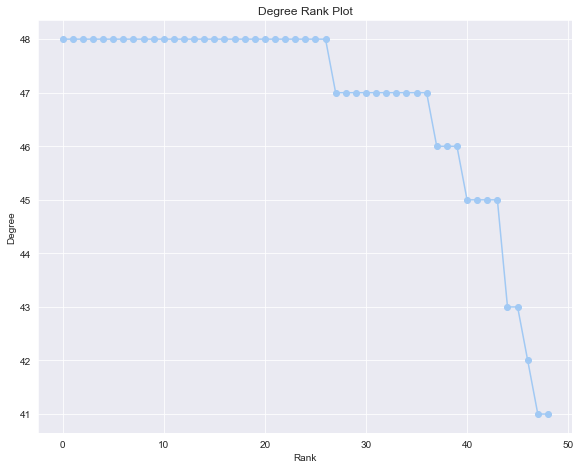

In [ ]:
#register the degrees of our node in descending order and plot them
degree_sequence = sorted((d for d in degree_distr), reverse=True)
fig = plt.figure("Degree of a random graph", figsize=(20, 20))
axgrid = fig.add_gridspec(5, 4)
ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, marker="o", color=sns.color_palette('pastel')[0])
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

plt.show()

* **A plot depicting the degree distribution of the network if it is G1**

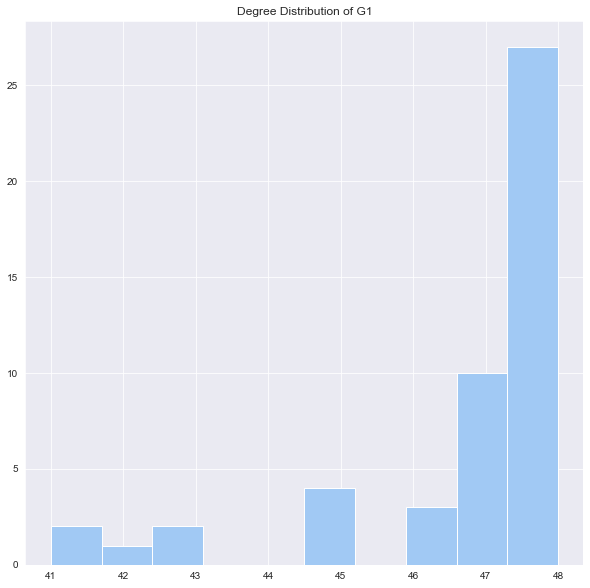

In [ ]:
#histogram of the degree distribution of the network
plt.figure(figsize=(10,10))
plt.hist(degree_distr, color=sns.color_palette('pastel')[0])
plt.title('Degree Distribution of G1')
plt.show()

These are the same results for the G2 graph

In [ ]:
n_nodes, number_heros, degrees, density, ave_degree, Hub, types=features(df_edges,G2, 50)

In [ ]:
data = [[n_nodes,  density, ave_degree, types]]
  
#define header names
col_names = ["Number of Nodes", "Density", "Average degree", "Type of the Network"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

#save hubs names
data=[]
for i in Hub:
    data.append([i])

#define header names
col_names = ["Hubs' Name"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════════╤═══════════╤══════════════════╤═══════════════════════╕
│   Number of Nodes │   Density │   Average degree │ Type of the Network   │
╞═══════════════════╪═══════════╪══════════════════╪═══════════════════════╡
│               320 │         0 │             11.3 │ Sparse                │
╘═══════════════════╧═══════════╧══════════════════╧═══════════════════════╛
╒══════════════╕
│ Hubs' Name   │
╞══════════════╡
│ M/SHSW 9     │
├──────────────┤
│ HR:R 4       │
├──────────────┤
│ M/GN 1       │
├──────────────┤
│ X 55         │
├──────────────┤
│ FF 367       │
├──────────────┤
│ H2 277       │
├──────────────┤
│ FF 368       │
├──────────────┤
│ H2 278       │
╘══════════════╛


Text(0.5, 0, 'Rank')

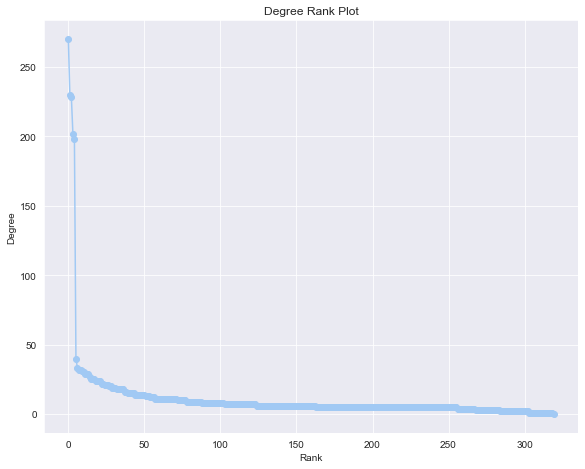

In [ ]:
#register the degrees of our node in descending order and plot them
sequence_de = sorted((d for d in degrees), reverse=True)
fig = plt.figure("Degree of a random graph", figsize=(20, 20))
axgrid = fig.add_gridspec(5, 4)
ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(sequence_de, marker="o", color=sns.color_palette('pastel')[0])
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

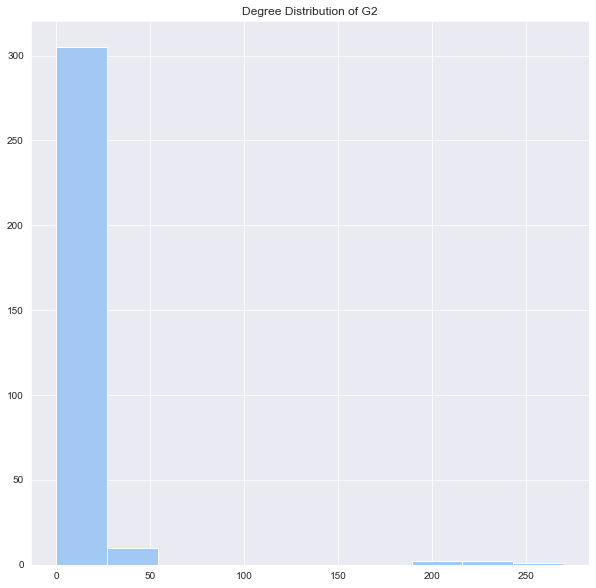

In [ ]:
#histogram of the degree distribution of the network
plt.figure(figsize=(10,10))
plt.hist(degrees, color=sns.color_palette('pastel')[0])
plt.title('Degree Distribution of G2')
plt.show()

### Visualization 2 - Visualize centrality measure

We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

- A table containing the information related to the requested centrality measure for:
    - The average of the requested centrality measure for all of the network's nodes
    - The requested centrality measure's value for the given node

Take all the metrics for a specific node and the avarage value for all the nodes

In [ ]:
between_values,node_between=top_superheroes(df_edges, 'CAPTAIN AMERICA', 'betweenness_centrality', 30)
avarage_between=np.average(np.array(between_values))

In [ ]:
pagerank_values, node_prank=top_superheroes(df_edges, 'CAPTAIN AMERICA', 'pagerank', 30)
avarage_prank=np.average(np.array(pagerank_values))

In [ ]:
close_values, node_close=top_superheroes(df_edges, 'CAPTAIN AMERICA', 'closeness_centrality', 30)
avarage_close=np.average(np.array(close_values))

In [ ]:
centr_values, node_centr=top_superheroes(df_edges, 'CAPTAIN AMERICA', 'degree_centrality', 30)
avarage_centr=np.average(np.array(centr_values))

A table with the centrality measure and the average value of the metrics and the value of the specific node

In [ ]:
data = [['betweenness_centrality',avarage_between, node_between],
       ['pagerank',avarage_prank,node_prank],
       ['closeness_centrality',avarage_close,node_close],
       ['degree_centrality', avarage_centr, node_centr]]
  
#define header names
col_names = ["Metric", "Avarage Value", "Node Value"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════════╤═════════════════╤══════════════╕
│ Metric                 │   Avarage Value │   Node Value │
╞════════════════════════╪═════════════════╪══════════════╡
│ betweenness_centrality │      0.00235014 │   0.00245181 │
├────────────────────────┼─────────────────┼──────────────┤
│ pagerank               │      0.00218818 │   0.00710277 │
├────────────────────────┼─────────────────┼──────────────┤
│ closeness_centrality   │      0.486416   │   0.367446   │
├────────────────────────┼─────────────────┼──────────────┤
│ degree_centrality      │      0.0270164  │   0.107456   │
╘════════════════════════╧═════════════════╧══════════════╛


Our node, ***CAPTAIN AMERICA***, has an higher degree rispect to the avarage of the network but the other measures are similar to the avarage. In general our nodes are close enough, but their pagerank and their betweenness are near to 0, in fact our network is sparse and its influence is not extensive.

### Visualization 3 - Visualize the shortest-ordered route

We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:

- Print the comics in the shortest walk in order
- Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

In [ ]:
def visualization_3(g: nx.Graph,
                    comic_path: List[str],
                    heroes: List[str],
                    N: int = None) -> None:
  """
  Args:
    - g: (nx.Graph): The graph data.
    - comic_path (List[str]): The list of comic that define the shortest walk.ù
    - heroes (List[str]): The list of heroes.
    - N (int): The number of heroes to consider in our top_N list of heroes. Default None.
  
  Return:
    - None
  """
  print(f"Comic path:\n{comic_path}")

  if N:
    subg = set()

    for hero in top_N[:N]:
      try:
        subg.update(g.neighbors(hero))
      except:
        continue
      else:
        subg.add(hero)
      
    graph = g.subgraph(subg)

  else:
    graph = g.copy()

  color_map = [sns.color_palette('pastel')[0] if node in comic_path else sns.color_palette('pastel')[1] if node in heroes else sns.color_palette('pastel')[9] for node in graph]

  node_size = [1000 if node in comic_path else 500 if node in heroes else 10 for node in graph]

  plt.figure(figsize=(10,10))
  nx.draw(graph, node_color=color_map, node_size=node_size)
  plt.title("Original Graph")
  plt.show()

  sub_graph = g.subgraph(comic_path+heroes)

  node_color = [sns.color_palette('pastel')[0] if node in comic_path else sns.color_palette('pastel')[1] for node in sub_graph]
  node_size = [1000 if node in comic_path else 500 for node in sub_graph]

  labels = {}

  for i, comic in enumerate(comic_path):
    labels[comic] = i+1

  for j, hero in enumerate(heroes):
    labels[hero] = ""

  plt.figure(figsize=(10,10))
  nx.draw(sub_graph, node_color=node_color, node_size=node_size, labels=labels)
  plt.title("The sugraph view of the shortpath")
  plt.show()

  return None

Example:

In [6]:
with open("G2.pkl", "rb") as f:
    G2 = pickle.load(f)

Comic path:
['H2 279', 'DD2 8', 'COC 1', 'O:MU']


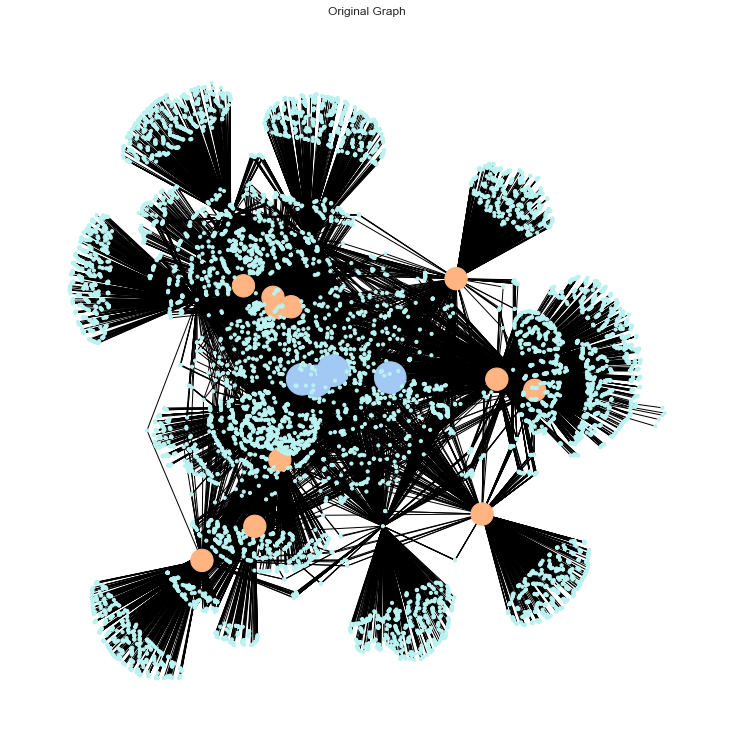

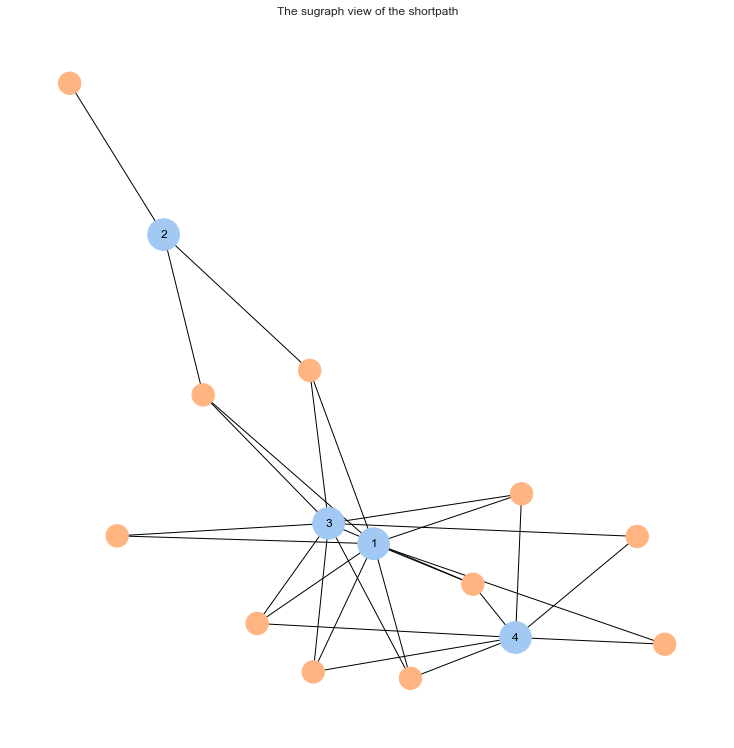

In [ ]:
graph = nx.Graph(G2)
N = 20

comic_path = functionality_3(graph,
                             top_N[10:20],
                             top_N[8],
                             top_N[10],
                             N)

heroes = [top_N[8]]

heroes += top_N[10:20]

heroes.append(top_N[10])

for hero in heroes:
  if hero not in top_N[:N]:
    heroes.remove(hero)

visualization_3(graph, comic_path, list(set(heroes)), N)

### Visualization 4 - Visualize the disconnected graph

We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:

- Print the number of the links that should be disconnected
- Plot the original graph
- Plot the graph after removing the links and identify the two nodes


In [7]:
def visualization_4(g: nx.Graph,
                    n_edges: Union[int, float],
                    S1: Set[str],
                    S2: Set[str],
                    heroA: str,
                    heroB: str) -> None:
  """
  Args:
    - g (nx.Graph): The graph data.
    - n_edges (Union[int, float]): The number of edges required to be cut.
    - S1 (Set[str]): The set on nodes for heroA.
    - S2 (Set[str]): The set on nodes for heroB.
    - heroA (Set[str]): Hero A.
    - heroB (Set[str]): Hero B.

  Returns:
    - None
  """
  print(f"Number of the links that should be disconnected: {n_edges}")

  color_map = []

  for node in g:
    if node in S1:
      if node == heroA:
        color_map.append(sns.color_palette('pastel')[0])
      else:
        color_map.append(sns.color_palette('pastel')[1])
    elif node in S2:
      if node == heroB:
        color_map.append(sns.color_palette('pastel')[2])
      else:
        color_map.append(sns.color_palette('pastel')[3])
    else:
      color_map.append(sns.color_palette('pastel')[4])

  node_size = [100 if node == heroA or node == heroB else 10 for node in g]

  plt.figure(figsize=(10,10))
  nx.draw(g, node_color=color_map, node_size=node_size)
  plt.title('The original graph')
  plt.show()

  graph1 = g.subgraph(S1)

  color_map = [sns.color_palette('pastel')[0] if node == heroA else sns.color_palette('pastel')[1] for node in graph1]
  node_size = [100 if node == heroA else 10 for node in graph1]

  plt.figure(figsize=(10,10))
  nx.draw(graph1, node_color=color_map, node_size=node_size)
  plt.title('The graph for only the heroA')
  plt.show()

  graph2 = g.subgraph(S2)

  color_map = [sns.color_palette('pastel')[2] if node == heroB else sns.color_palette('pastel')[3] for node in graph2]
  node_size = [100 if node == heroB else 10 for node in graph2]

  plt.figure(figsize=(10,10))
  nx.draw(graph2, node_color=color_map, node_size=node_size)
  plt.title('The graph for only the heroB')
  plt.show()


  return None

Example:

Number of the links that should be disconnected: 145


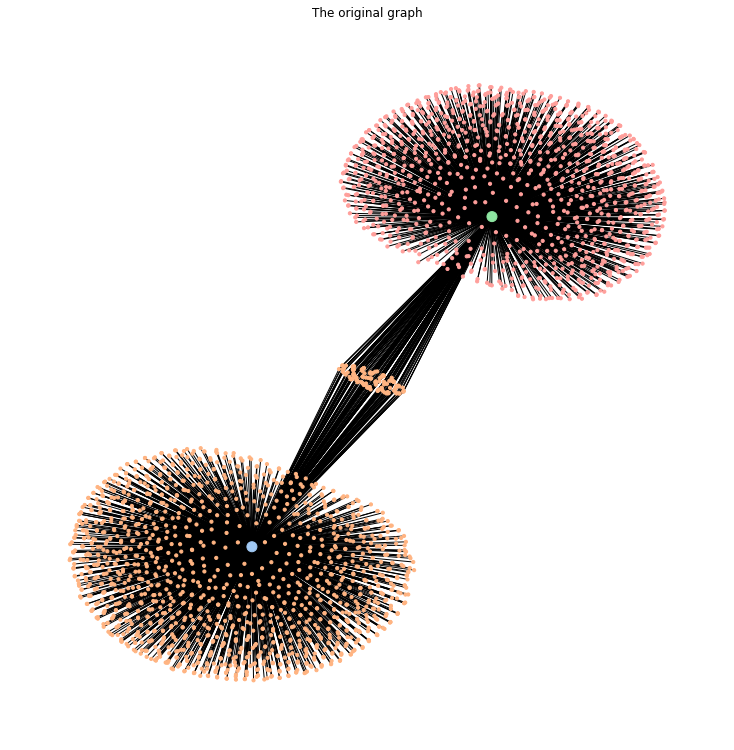

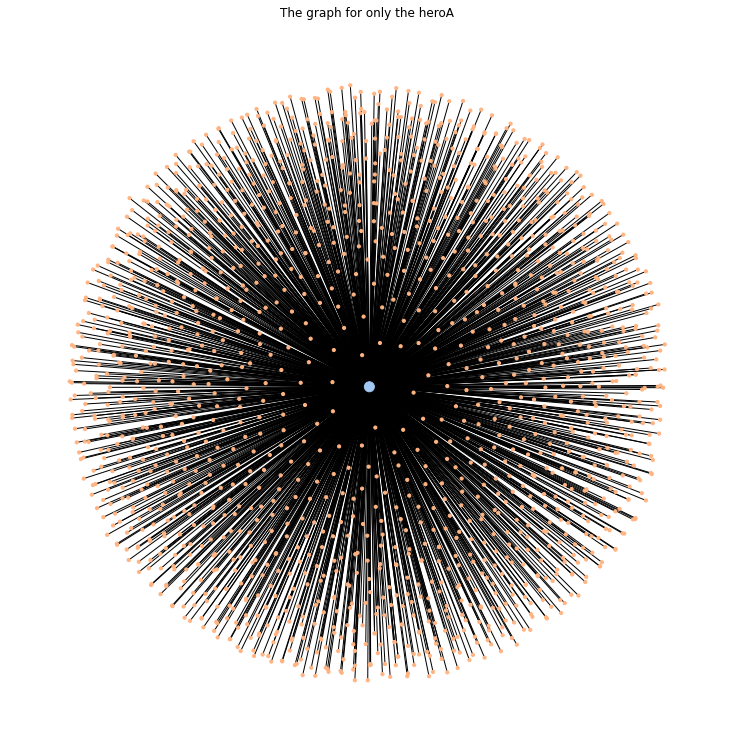

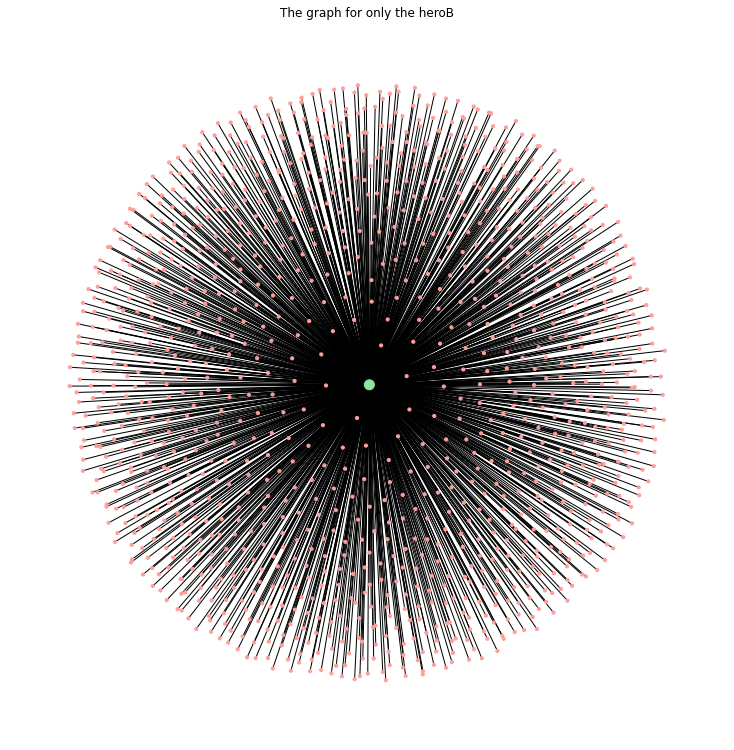

In [8]:
heroA = top_N[0]
heroB = top_N[1]
N = 2

graph = nx.Graph(G2)

if N:
  subg = set()

  for hero in top_N[:N]:
    try:
      subg.update(graph.neighbors(hero))
    except:
      continue
    else:
      subg.add(hero)
    
  graph = graph.subgraph(subg)

n_edges, S1, S2 = functionality_4(graph, heroA, heroB, N)

visualization_4(graph, n_edges, S1, S2, heroA, heroB)

### Visualization 5 - Visualize the communities

We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

- Print the number of links that should be removed to have the communities
- A table depicting the communities and the heroes that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Hero_1 and Hero_2

__Notes:__

- For the final output of your function, please set the Hero_1 to 'Captain America' and Hero_2 to 'Ironman' and show the results
- If Hero_1 and Hero_2 belong to the same community, identify that community; otherwise, identify those two communities that these heroes belong to.

***

First of all let's run the functionality 5 with N=50, hero1='CAPTAIN AMERICA' and hero2='IRON MAN/TONY STARK'

In [ ]:
N = 50
hero1 = 'CAPTAIN AMERICA'
hero2 = 'IRON MAN/TONY STARK'
min_edges_to_remove, communities, same_community = extract_communities(G1, N, hero1, hero2)

- Print the number of links that should be removed to have the communities

In [ ]:
print(f'Number of links to be removed: {min_edges_to_remove}')

Number of links to be removed: 42


- Table depicting the communities and the heroes that belong to each community

In [ ]:
# initialize the table
table = []

# create a list of all heroes in the communities
all_heroes = [hero for community in communities for hero in community]

# create a list of column headers
headers = ['Hero'] + [f'Community {i+1}' for i in range(len(communities))]

# create a row for each hero
for hero in all_heroes:
    row = [hero]
    # add a column for each community
    for community in communities:
        if hero in community:
            row.append('X')
        else:
            row.append('')
    table.append(row)

print(tabulate(table, headers=headers, tablefmt="fancy_grid", stralign="center"))

╒═════════════════════════╤═══════════════╤═══════════════╕
│          Hero           │  Community 1  │  Community 2  │
╞═════════════════════════╪═══════════════╪═══════════════╡
│  RICHARDS, FRANKLIN B   │       X       │               │
├─────────────────────────┼───────────────┼───────────────┤
│  HUMAN TORCH/JOHNNY S   │       X       │               │
├─────────────────────────┼───────────────┼───────────────┤
│ SPIDER-MAN/PETER PARKER │       X       │               │
├─────────────────────────┼───────────────┼───────────────┤
│          HAWK           │       X       │               │
├─────────────────────────┼───────────────┼───────────────┤
│       PARKER, MAY       │       X       │               │
├─────────────────────────┼───────────────┼───────────────┤
│  NIGHTCRAWLER/KURT WA   │       X       │               │
├─────────────────────────┼───────────────┼───────────────┤
│   SCARLET WITCH/WANDA   │       X       │               │
├─────────────────────────┼─────────────

- Plot the original graph

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


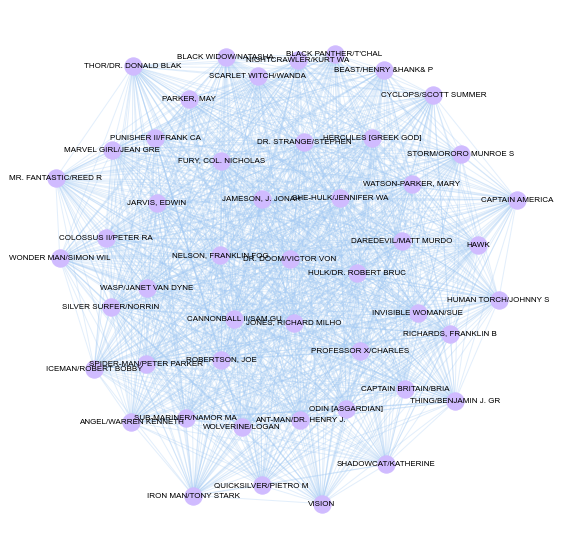

In [ ]:
# take the same subgraph used to run the functionality
sub_G1 = G1.subgraph(top_N[:N]).copy()

# setting the layout
pos = nx.spring_layout(sub_G1)

plt.figure(figsize=(10,10))
# create the plot step by step to make it more customizable
nx.draw_networkx_edges(sub_G1, pos=pos, edge_color=sns.color_palette('pastel')[0], alpha=0.3)
nx.draw_networkx_nodes(sub_G1, pos=pos, node_color=sns.color_palette('pastel')[4])
nx.draw_networkx_labels(sub_G1, pos=pos, font_color='black', font_size=8)

plt.axis('off')
plt.show()

- Plot the graph showing the communities in the network

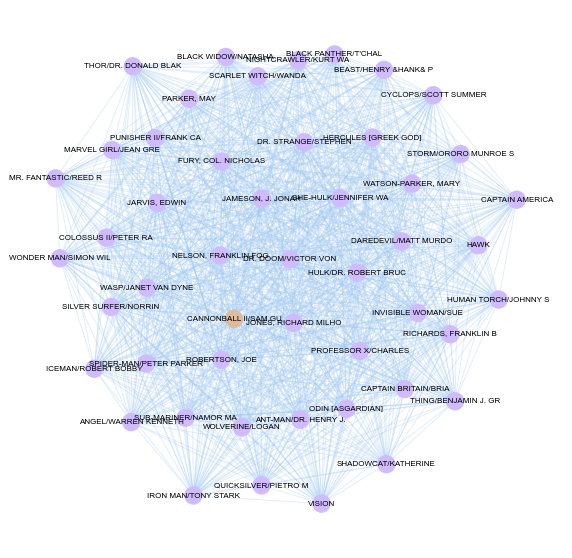

In [ ]:
# create a list of colors for each node given by the community
node_colors = []
for node in sub_G1.nodes():
    for i, community in enumerate(communities):
        if node in community:
            node_colors.append(sns.color_palette('pastel')[i+4])

plt.figure(figsize=(10,10))

nx.draw_networkx_edges(sub_G1, pos=pos, edge_color=sns.color_palette('pastel')[0], alpha=0.3)
nx.draw_networkx_nodes(sub_G1, pos=pos, node_color=node_colors)
nx.draw_networkx_labels(sub_G1, pos=pos, font_color='black', font_size=8)

plt.axis('off')
plt.show()

- Plot the final graph and identify the community/communities of Hero_1 and Hero_2

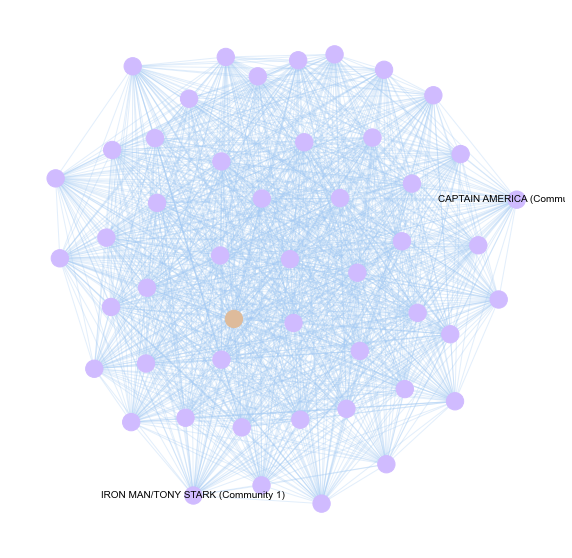

In [ ]:
# dictionary to create the merged labels for Hero_1 and Hero_2 and their community
labels = {}
for i, community in enumerate(communities):
    if hero1 in community:
        labels[hero1] = f'{hero1} (Community {i+1})'
    if hero2 in community:
        labels[hero2] = f'{hero2} (Community {i+1})'

plt.figure(figsize=(10,10))

nx.draw_networkx_edges(sub_G1, pos=pos, edge_color=sns.color_palette('pastel')[0], alpha=0.3)
nx.draw_networkx_nodes(sub_G1, pos=pos, node_color=node_colors)
nx.draw_networkx_labels(sub_G1, pos=pos, font_color='black', font_size=10, labels=labels)

plt.axis('off')
plt.show()

## 4. Command Line Question

In this question, you should use any command line tools that you know to answer the following questions using the same datasets that you have been using so far:

- What is the most popular pair of heroes (often appearing together in the comics)?
- Number of comics per hero.
- The average number of heroes in comics.

__Note:__ You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.


## 5. Bonus - PageRank on MapReduce

__IMPORTANT:__ This is a bonus step, so it's not mandatory. You can get the maximum score also without doing this. We will take this into account, __only if__ the rest of the homework has been completed.

1. PageRank and MapReduce go well together, and this synergy was essential for Google's growth and the MapReduce paradigm's proliferation. Therefore, for the bonus section of this homework, we ask that you __implement the PageRank algorithm using the MapReduce paradigm.__

Hint: [Here](https://www.cs.utah.edu/~jeffp/teaching/cs5140-S15/cs5140/L24-MR+PR.pdf) are __two approaches__ to implementing the PageRank algorithm using the MapReduce paradigm that you can use as a reference for your bonus part.

The Internet is stored as a big matrix ***M*** (size n × n). Specifically the column-normalized adjacency matrix
where each column represents a webpage and where it links to are the non-zero entries.
Break M into k vertical stripes M = [M1 M2 . . . Mk] so each Mj fits on a machine. İnitiate _**q**_ as a vector of PageRank with  values as 1/number of pages(n).
* _**Mapper:**_  j → key= j' ∈ [k] ; value = row r of Mj ∗ qj
* _**Reducer:**_  adds values for each key i to get qi+1[j] ∗ β + (1 − β)/n.

typically β = 0.85.

In [ ]:
with open("G1.pkl", "rb") as file:
    G1 = pickle.load(file)

In [ ]:
def top_N_G1(data,N=G1.number_of_nodes()):
    top=data['hero'].value_counts().head(N)
    hero_list=top.index.tolist()
    return hero_list

In [ ]:
#Create a dataframe with the edges datas
df_edges = pd.read_csv('edges.csv')

#Extract the subgraph of the top_N heros for the first graph
hero_list=top_N_G1(df_edges, 500)
top=G1.subgraph(hero_list)

In [ ]:
#Create the adjacency matrix of the first graph
M_G1=nx.to_numpy_matrix(top)
Matrix=M_G1.tolist()

#Save the length of M_G1 as n
n1=len(M_G1)

#Beta is usually sets as 0.85
beta=0.85

In [ ]:
#Set up the Spark context
sc = SparkContext()

In [ ]:
#Convert M_G1 to RDDs (into k vertical stripes)
M_rdd = sc.parallelize(np.transpose(Matrix))
rddCollect = M_rdd.collect()
N=M_rdd.count()

#Inizialize q
q =[]
for i in range(N):
    q.append(1/N)

In [ ]:
def mapper(row,q):
    m=[]
    for i in range(len(row)):
        m.append(((i+1),row[i]*q[0]))
    return m

In [ ]:
#Map the grouped tiles
M_mapped=M_rdd.flatMap(lambda x: mapper(x,q))

#Reduce the mapped output by adding the values for each row
M_reduced = M_mapped.reduceByKey(lambda x, y: x + y)

#Update the values of q using the map-reduce output
q_updated = M_reduced.map(lambda row: (row[0], row[1] * beta + (1 - beta) / n1))

#Return the updated values of q
c=q_updated.collect()
c[:10]

[(2, 0.10016190035063106),
 (4, 0.1986695519750855),
 (6, 0.17743980344805738),
 (8, 0.08122033085994863),
 (10, 0.1233882818284333),
 (12, 0.11635272965760857),
 (14, 0.6187876090383257),
 (16, 0.2654296840031845),
 (18, 0.2086029757399857),
 (20, 0.07413488952437754)]

In [ ]:
#Take matrix M from the example on the pdf file
M=[[0, 0.5, 0, 0],
   [0.3, 0, 1, 0.5],
   [0.3, 0, 0, 0.5],
   [0.3, 0.5, 0, 0]]

n=len(M)

In [ ]:
#Convert M to RDDs (into k vertical stripes)
M_rdd = sc.parallelize(np.transpose(M))
rddCollect = M_rdd.collect()
N=M_rdd.count()

#Inizialize q
q =[]
for i in range(N):
    q.append(1/N)

In [ ]:
#Map the grouped tiles
M_mapped=M_rdd.flatMap(lambda x: mapper(x,q))

#Reduce the mapped output by adding the values for each row
M_reduced = M_mapped.reduceByKey(lambda x, y: x + y)

#Update the values of q using the map-reduce output
q_updated = M_reduced.map(lambda row: (row[0], row[1] * beta + (1 - beta) / n))

#Return the updated values of q
q_updated.collect()

[(2, 0.42000000000000004),
 (4, 0.20750000000000002),
 (1, 0.14375),
 (3, 0.20750000000000002)]

Where q is a probability vector with tuples where the first values are equal to the number of a spacific node (one of n), the second values are the probability that you are in that node.

In [ ]:
#Stop the Spark context
sc.stop()

## 6. Algorithmic Question

Alex and Sarah have been together for two years, and Alex is now thinking about proposing to her. But, to surprise her, he wants to install an app on her phone that asks her if she will marry him at the right time.

However, to install the application secretly, he needs her phone's password, which he does not have. He knows her password is a __poly-line made up of vertical or horizontal line segments__. In a __3*3__ grid, each line segment connects the centres of two cells. Alex learned the direction of each line segment by looking at her hand while unlocking her phone. He didn't pay much attention to the length of each line segment, but he is sure that her phone's operating system __does not allow__ the poly-line __to intersect with itself even at one point.__

Alex wants to distract Sarah's attention long enough to test all possible patterns based on the directions of the line segments he has learned. Therefore, he needs you to assist him in calculating how many possible patterns he has to try based on those directions to estimate how much time he needs to check all of those possibilities. Given that the line segments were directed right, down, left, and up, the following figure depicts __two valid__ and __one invalid__ (as the poly-lines should not intersect even in one point) patterns.

__Input:__

The input is a __single string__ that shows the direction of the segment lines and contains only the characters R, L, U, and D, which correspond to the Right, Left, Up, and Down directions. The string's maximum length is __10__. It is also guaranteed that two consecutive characters will be different.

__Ouput:__

We expect to see only __1 number__ in the output, corresponding to the number of different patterns that can be generated based on the line segments Alex learned. In some cases, this number __may be 0__, indicating that no patterns can be generated using the learned line segments.

#### Examples:

__Input 1__

`DRU`

__Output 1__

`15`

__Input 2__

`R`

__Output 2__

`9`

__Input 3__

`LDRDRUL`

__Output 3__

`0`

***

The idea behind solving this algorithm consists of:
- Given a string of coordinates, find all possible coordinates by doubling the single directions. Example: \
    Input -> 'abc' \
    Output -> 'abc', 'abcc', 'abbc', 'aabc', 'aabbc', 'aabcc', 'abbcc', 'aabbcc'
- Create a 3x3 matrix and try (starting from each possible of the 9 points) all the paths deriving from all the possible coordinates found. The matrix will initially be composed of 0s which will be updated with 1 when passing through that point, this will be used as a stopping condition if a 1 is encountered along the way. The further stopping condition is that one cannot exit the limits of the 3x3 matrix

To obtain this result, 3 functions will be created: the first will be used to find all the possible combinations, the second to update the coordinates of the point where we are located, the third will be the main function in which we will try all the starting points and in which we will will be the stopping conditions.

**Step 1:** function to find all the possible combinations of coordinates.

In [ ]:
def find_combinations(string, index, result, final_list):
  if index == len(string):
    final_list.append(result)
    return
  # double the current letter
  result += string[index] + string[index]
  find_combinations(string, index + 1, result, final_list)
  result = result[:-2]
  # do not double the current letter
  result += string[index]
  find_combinations(string, index + 1, result, final_list)
  result = result[:-1]
  return final_list

**Step 2:** function to update the position based on the coordinate

In [ ]:
def update_coord(coord, direction):
    # based on the letter update the position inside the matrix
    if direction=='U':
        coord = (coord[0]-1, coord[1])
    elif direction=='D':
        coord = (coord[0]+1, coord[1])
    elif direction=='L':
        coord = (coord[0], coord[1]-1)
    else:
        coord = (coord[0], coord[1]+1)
    return coord

**Step 3:** main function

In [ ]:
def possible_combinations(directions):
    new_list = []
    combinations = find_combinations(directions, 0, "", new_list)
    starting_points = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
    counter = 0
    # try all the starting points
    for start in starting_points:
        # loop trough every possible combination
        for comb in combinations:
            matrix = np.zeros((3, 3))
            matrix[start] = 1
            coord = start
            # update the position for each direction
            for direction in comb:
                check = True
                coord = update_coord(coord, direction)
                # check that we are into the matrix limits
                if (coord[0] <= 2) & (coord[0] >= 0) & (coord[1] <= 2) & (coord[1] >= 0):
                    if matrix[coord] == 0:
                        matrix[coord] = 1
                    else:
                        check = False
                        break
                else:
                    check = False
                    break
            if check == True:
                counter += 1
    return counter

In [ ]:
directions = "DRU"
possible_combinations(directions)

15

In [ ]:
directions = "R"
possible_combinations(directions)

9

In [ ]:
directions = "LDRDRUL"
possible_combinations(directions)


0